In [16]:
#fetch GFS data and plot at ENA
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline


In [2]:
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
best_gfs.datasets
best_ds = list(best_gfs.datasets.values())[0]
best_ds.access_urls


{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p5deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg/Best'}

In [6]:
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])


In [11]:
query = ncss.query()
now = datetime.utcnow()
gra_lat = 39.0525
gra_lon = -28.0069
query.lonlat_point(gra_lon, gra_lat).vertical_level(0).time_range(now, now + timedelta(days=7))
query.variables('Temperature_height_above_ground',
               'Dewpoint_temperature_height_above_ground').accept('netcdf')
data = ncss.get_data(query)
list(data.variables.keys())


['height_above_ground',
 'Dewpoint_temperature_height_above_ground',
 'height_above_ground4',
 'Temperature_height_above_ground',
 'station_name',
 'station_description',
 'latitude',
 'longitude',
 'time']

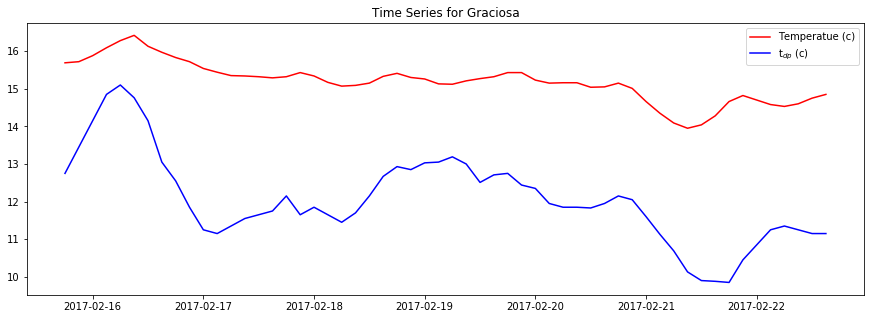

In [12]:
temp = data.variables['Temperature_height_above_ground']
dp = data.variables['Dewpoint_temperature_height_above_ground']
time = data.variables['time']
datetimes = num2date(time[:].squeeze(), time.units)
fig = plt.figure(figsize = [15,5])
plt.plot(datetimes, temp[:].squeeze()-273.15, 'r-', label='Temperatue (c)')
plt.plot(datetimes, dp[:].squeeze()-273.15, 'b-', label=r't$_{dp}$ (c)')
plt.legend()
plt.title('Time Series for Graciosa')


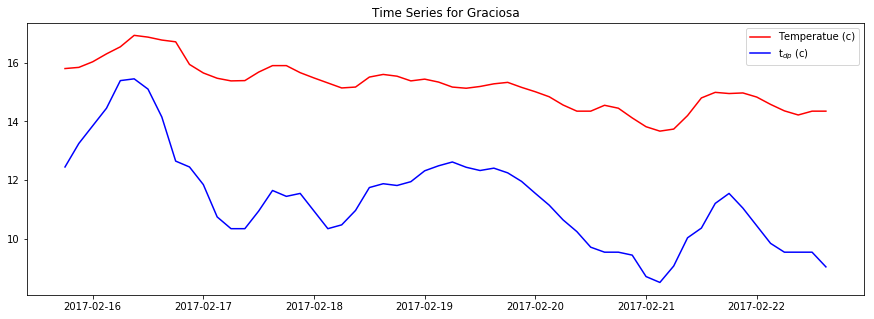

In [13]:
ter_lat = 38.7216
ter_lon = -27.2206
query = ncss.query()
query.lonlat_point(ter_lon, ter_lat).vertical_level(0).time_range(now, now + timedelta(days=7))
query.variables('Temperature_height_above_ground',
               'Dewpoint_temperature_height_above_ground').accept('netcdf')
data = ncss.get_data(query)
temp = data.variables['Temperature_height_above_ground']
dp = data.variables['Dewpoint_temperature_height_above_ground']
time = data.variables['time']
datetimes = num2date(time[:].squeeze(), time.units)
fig = plt.figure(figsize = [15,5])
plt.plot(datetimes, temp[:].squeeze()-273.15, 'r-', label='Temperatue (c)')
plt.plot(datetimes, dp[:].squeeze()-273.15, 'b-', label=r't$_{dp}$ (c)')
plt.legend()
plt.title('Time Series for Tericia')



['Temperature_surface', 'reftime', 'time', 'lat', 'lon']


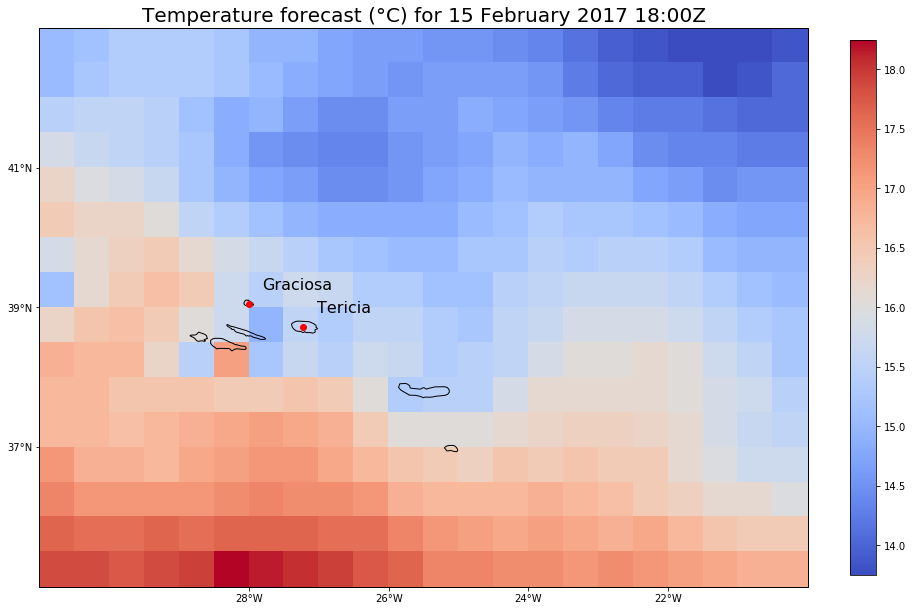

In [32]:
query = ncss.query()
query.lonlat_box(north=43, south=35, east=-20, west=-31).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Temperature_surface')
data = ncss.get_data(query)
print(list(data.variables))
temp_var = data.variables['Temperature_surface']

# Time variables can be renamed in GRIB collections. Best to just pull it out of the
# coordinates attribute on temperature
time_name = temp_var.coordinates.split()[1]
time_var = data.variables[time_name]
lat_var = data.variables['lat']
lon_var = data.variables['lon']

temp_vals = temp_var[:].squeeze()
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()

# Convert the number of hours since the reference time to an actual date
time_val = num2date(time_var[:].squeeze(), time_var.units)

# Convert temps to Fahrenheit from Kelvin
temp_vals = temp_vals - 273.15

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([-22, -24, -26, -28 ], crs=ccrs.PlateCarree())
ax.set_yticks([37,39,41], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent([-20., -31., 35, 43])

# Add state boundaries to plot
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
_ = ax.add_feature(coast, edgecolor='black')

#ax.add_feature(cfeature.NaturalEarthFeature, edgecolor='black', linewidth=2)

# Contour temperature at each lat/long
cf = ax.pcolormesh(lon_2d, lat_2d, temp_vals, transform=ccrs.PlateCarree(), zorder=0,
                 cmap='coolwarm')

# Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(cf, ax=ax, fraction=0.032)

# Make a title with the time value
ax.set_title(u'Temperature forecast (\u00b0C) for {0:%d %B %Y %H:%MZ}'.format(time_val),
             fontsize=20)


ax.plot([ter_lon, gra_lon], [ter_lat, gra_lat],
       'ro', transform=ccrs.PlateCarree())

ax.text(ter_lon+.2, ter_lat+.2, 
        'Tericia', transform=ccrs.PlateCarree(), fontsize = 16)

ax.text(gra_lon+.2, gra_lat+.2, 
        'Graciosa', transform=ccrs.PlateCarree(), fontsize = 16)


['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']


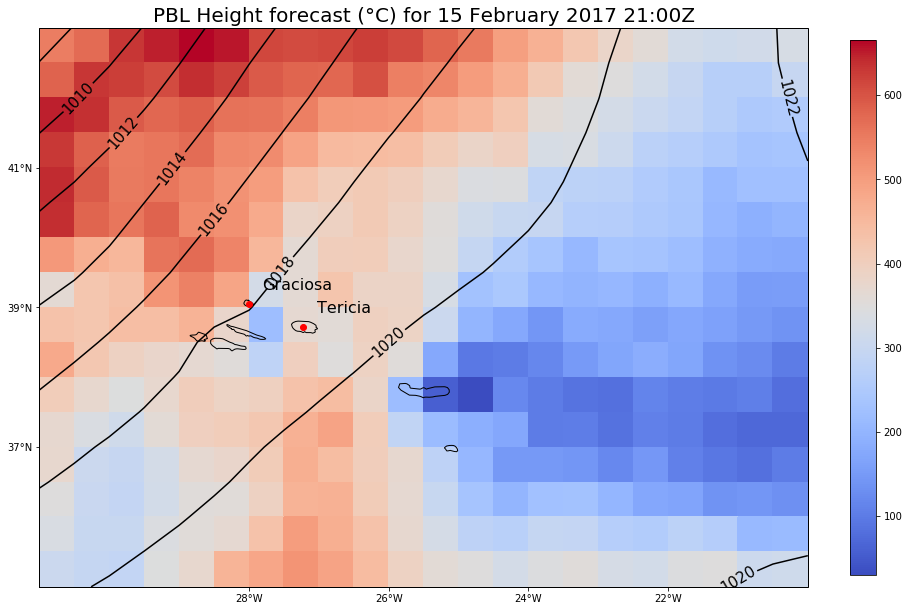

In [49]:
query = ncss.query()
query.lonlat_box(north=43, south=35, east=-20, west=-31).time(datetime.utcnow())
query.accept('netcdf4')
query.variables('Planetary_Boundary_Layer_Height_surface', 'MSLP_Eta_model_reduction_msl')
data = ncss.get_data(query)
print(list(data.variables))
pbl_var = data.variables['Planetary_Boundary_Layer_Height_surface']
mslp_var = data.variables['MSLP_Eta_model_reduction_msl']

# Time variables can be renamed in GRIB collections. Best to just pull it out of the
# coordinates attribute on temperature
time_name = temp_var.coordinates.split()[1]
time_var = data.variables[time_name]
lat_var = data.variables['lat']
lon_var = data.variables['lon']

pbl_vals = pbl_var[:].squeeze()
lat_vals = lat_var[:].squeeze()
lon_vals = lon_var[:].squeeze()
mslp_vals = mslp_var[:].squeeze() / 100.0 

# Convert the number of hours since the reference time to an actual date
time_val = num2date(time_var[:].squeeze(), time_var.units)


# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([-22, -24, -26, -28 ], crs=ccrs.PlateCarree())
ax.set_yticks([37,39,41], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent([-20., -31., 35, 43])

# Add state boundaries to plot
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
_ = ax.add_feature(coast, edgecolor='black')


# Contour temperature at each lat/long
cf = ax.pcolormesh(lon_2d, lat_2d, pbl_vals, transform=ccrs.PlateCarree(), zorder=0,
                 cmap='coolwarm')

cn = ax.contour(lon_2d, lat_2d, mslp_vals, np.arange(1000, 1040, 2), colors='black')

plt.clabel(cn, inline=1, fontsize=15, fmt='%1.0f')


# Plot a colorbar to show temperature and reduce the size of it
plt.colorbar(cf, ax=ax, fraction=0.032)

# Make a title with the time value
ax.set_title(u'PBL Height forecast (\u00b0C) for {0:%d %B %Y %H:%MZ}'.format(time_val),
             fontsize=20)


ax.plot([ter_lon, gra_lon], [ter_lat, gra_lat],
       'ro', transform=ccrs.PlateCarree())

ax.text(ter_lon+.2, ter_lat+.2, 
        'Tericia', transform=ccrs.PlateCarree(), fontsize = 16)

ax.text(gra_lon+.2, gra_lat+.2, 
        'Graciosa', transform=ccrs.PlateCarree(), fontsize = 16)


In [64]:
def pblplot(ncss, bbox, delta=0, tk=.5):
    north = bbox[3]
    south = bbox[2]
    west = bbox[1]
    east = bbox[0]
    query = ncss.query()
    query.lonlat_box(north=north, south=south, 
                     east=east, west=west).time(datetime.utcnow() + timedelta(hours=delta))
    query.accept('netcdf4')
    query.variables('Planetary_Boundary_Layer_Height_surface', 'MSLP_Eta_model_reduction_msl')
    data = ncss.get_data(query)
    print(list(data.variables))
    pbl_var = data.variables['Planetary_Boundary_Layer_Height_surface']
    mslp_var = data.variables['MSLP_Eta_model_reduction_msl']

    # Time variables can be renamed in GRIB collections. Best to just pull it out of the
    # coordinates attribute on temperature
    time_name = temp_var.coordinates.split()[1]
    time_var = data.variables[time_name]
    lat_var = data.variables['lat']
    lon_var = data.variables['lon']

    pbl_vals = pbl_var[:].squeeze()
    lat_vals = lat_var[:].squeeze()
    lon_vals = lon_var[:].squeeze()
    mslp_vals = mslp_var[:].squeeze() / 100.0 

    # Convert the number of hours since the reference time to an actual date
    time_val = num2date(time_var[:].squeeze(), time_var.units)


    # Combine 1D latitude and longitudes into a 2D grid of locations
    lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

    # Create a new figure
    fig = plt.figure(figsize=(15, 12))

    # Add the map and set the extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_extent(bbox)

    # Add state boundaries to plot
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                                facecolor='none', name='coastline')
    _ = ax.add_feature(coast, edgecolor='black')


    # Contour temperature at each lat/long
    cf = ax.pcolormesh(lon_2d, lat_2d, pbl_vals, transform=ccrs.PlateCarree(), zorder=0,
                     cmap='coolwarm', vmin=0, vmax=1750)

    cn = ax.contour(lon_2d, lat_2d, mslp_vals, np.arange(1000, 1040, 2), colors='black')

    plt.clabel(cn, inline=1, fontsize=15, fmt='%1.0f')


    # Plot a colorbar to show temperature and reduce the size of it
    plt.colorbar(cf, ax=ax, fraction=0.032)

    # Make a title with the time value
    ax.set_title(u'PBL Height forecast (\u00b0C) for {0:%d %B %Y %H:%MZ}'.format(time_val),
                 fontsize=20)


    ax.plot([ter_lon, gra_lon], [ter_lat, gra_lat],
           'ro', transform=ccrs.PlateCarree())

    ax.text(ter_lon+.2, ter_lat+.2, 
            'Tericia', transform=ccrs.PlateCarree(), fontsize = 16)

    ax.text(gra_lon+.2, gra_lat+.2, 
            'Graciosa', transform=ccrs.PlateCarree(), fontsize = 16)


['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']


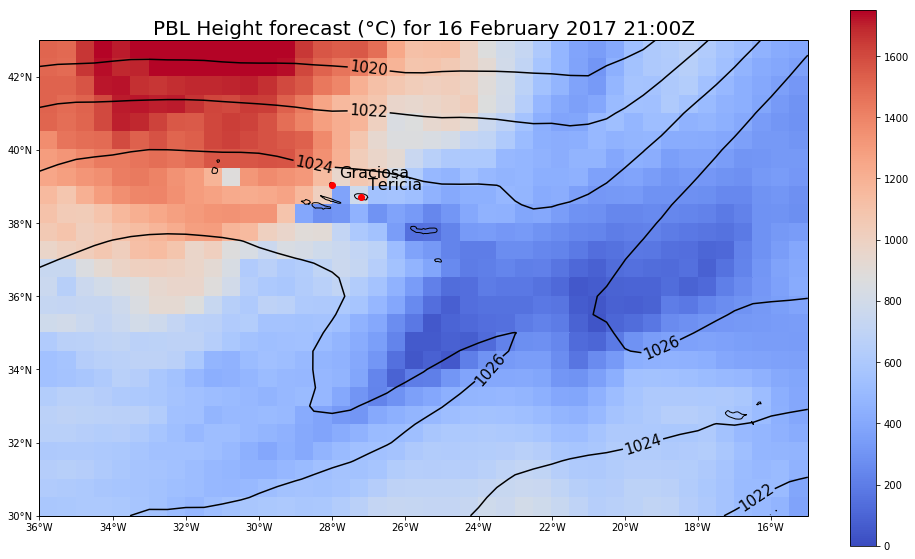

In [65]:
pblplot(ncss, [-15., -36., 30, 43], delta=24, tk=2)

['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']


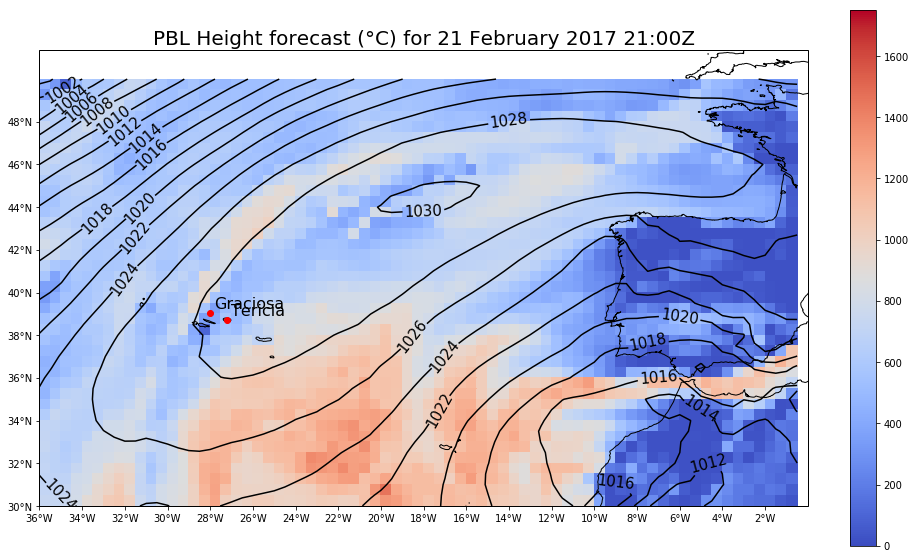

In [66]:
pblplot(ncss, [0, -36., 30, 50], delta=144, tk=2)

/Users/scollis//aceena_000.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']
/Users/scollis//aceena_001.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']
/Users/scollis//aceena_002.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']
/Users/scollis//aceena_003.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']
/Users/scollis//aceena_004.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']
/Users/scollis//aceena_005.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']
/Users/scollis//aceena_006.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']
/Users/scollis//acee

/Users/scollis/anaconda/envs/ams-workshop/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/Users/scollis//aceena_021.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']


/Users/scollis/anaconda/envs/ams-workshop/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/Users/scollis//aceena_022.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']


/Users/scollis/anaconda/envs/ams-workshop/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/Users/scollis//aceena_023.png
['MSLP_Eta_model_reduction_msl', 'reftime', 'time', 'lat', 'lon', 'Planetary_Boundary_Layer_Height_surface']


/Users/scollis/anaconda/envs/ams-workshop/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


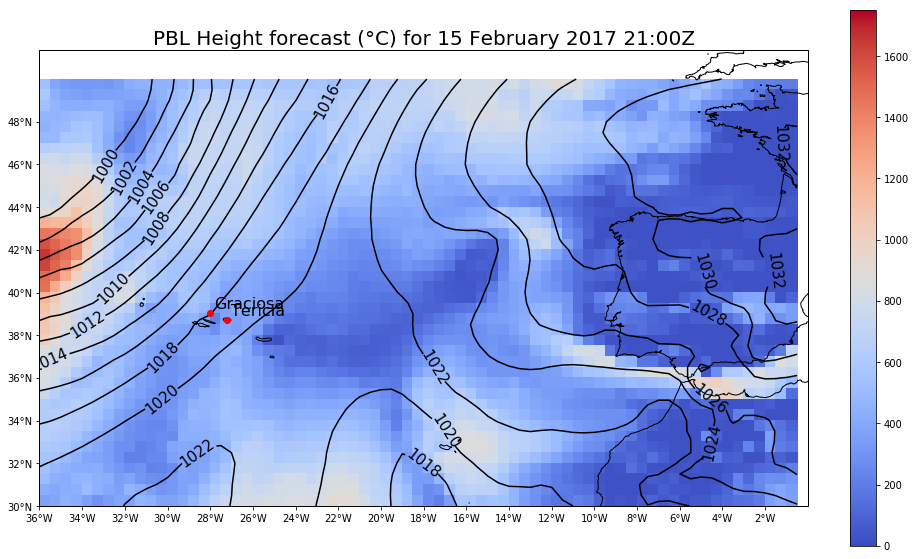

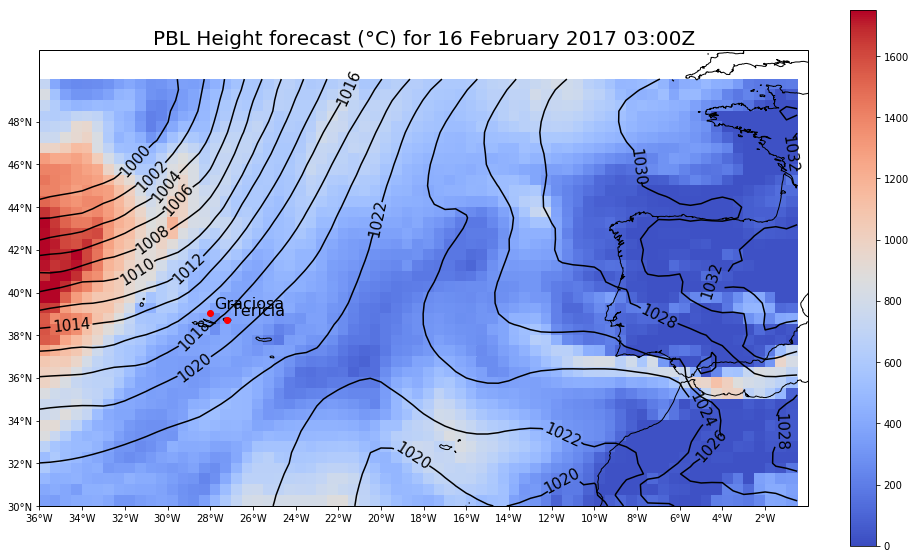

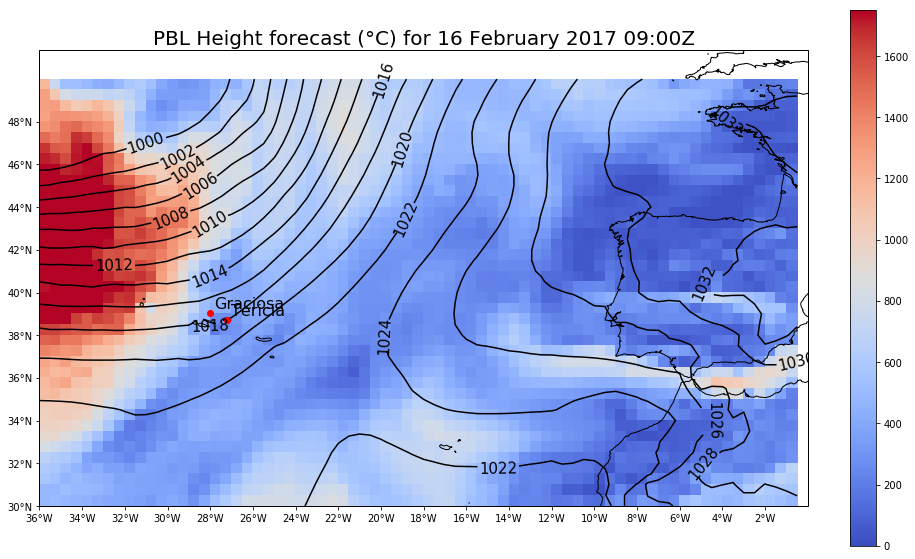

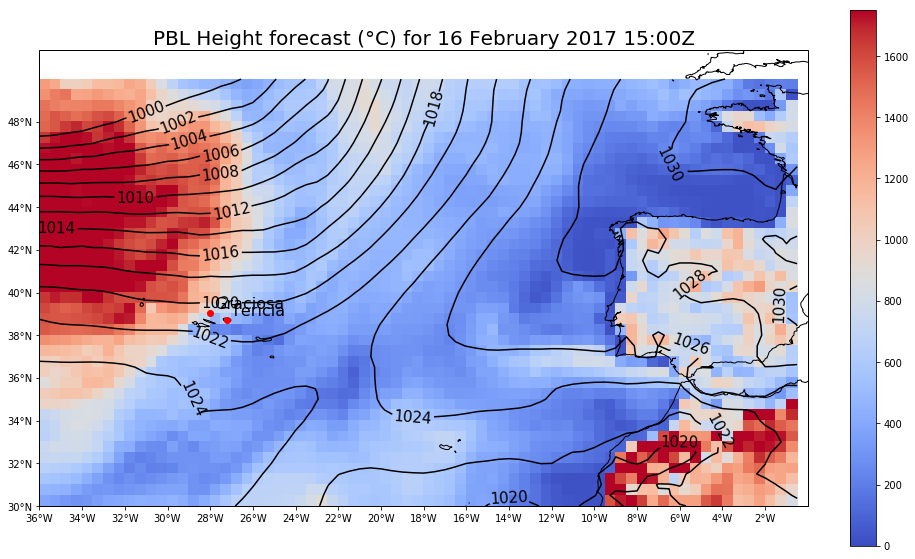

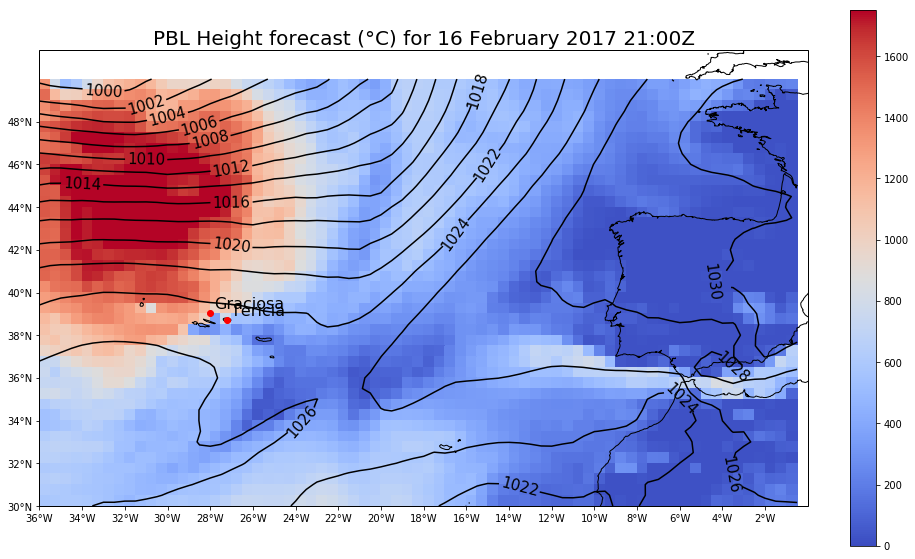

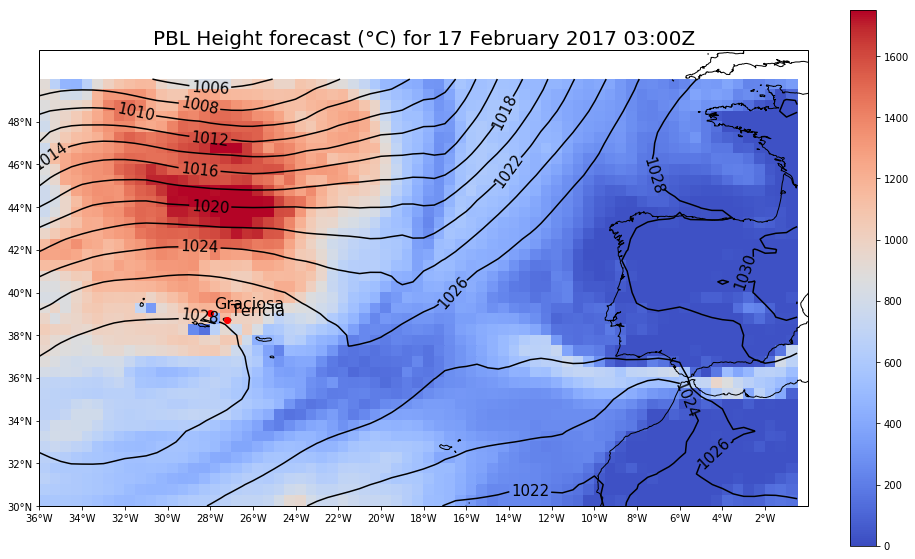

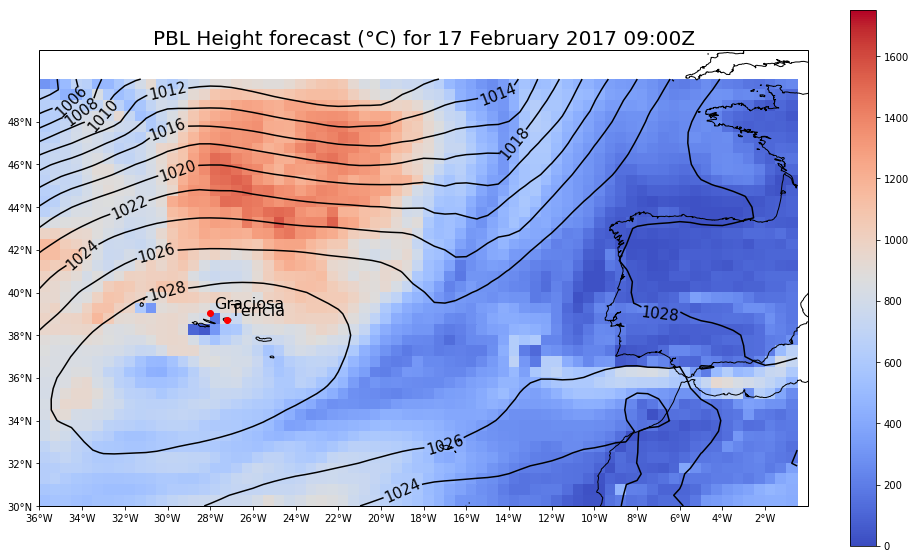

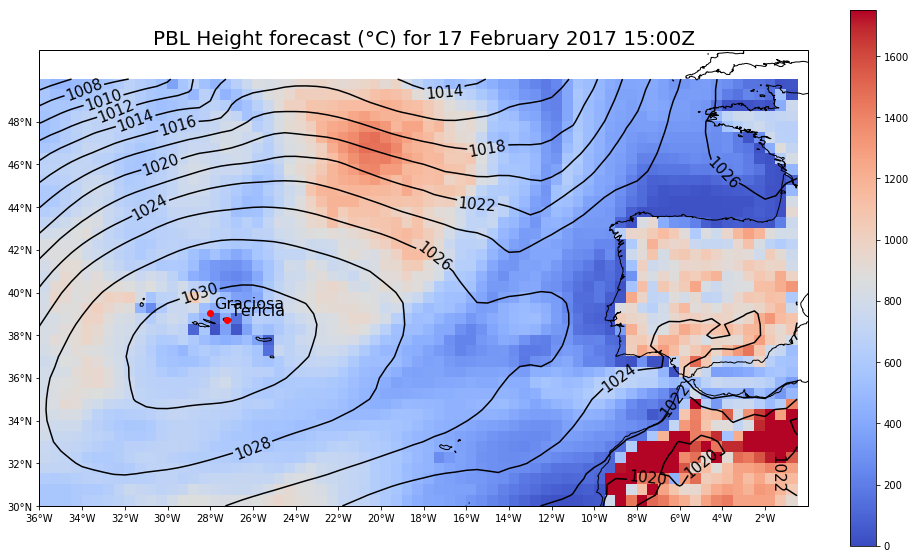

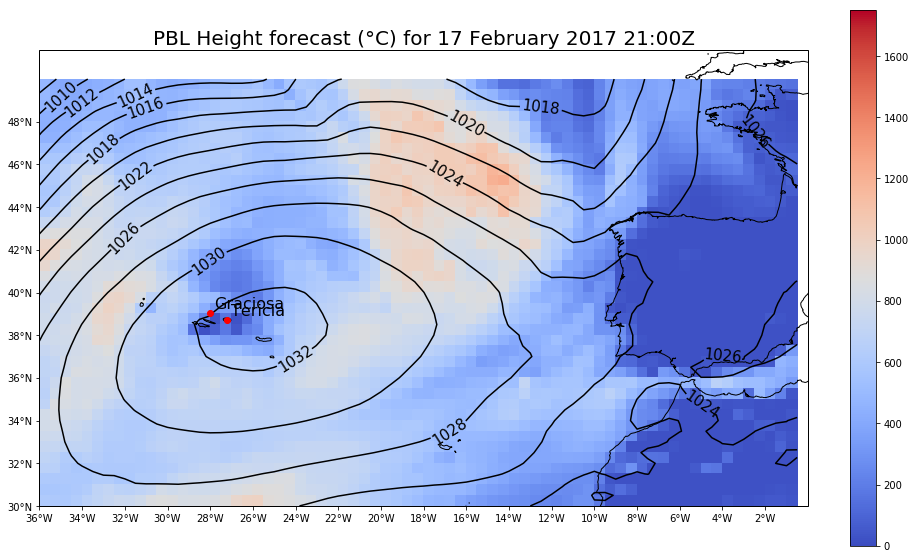

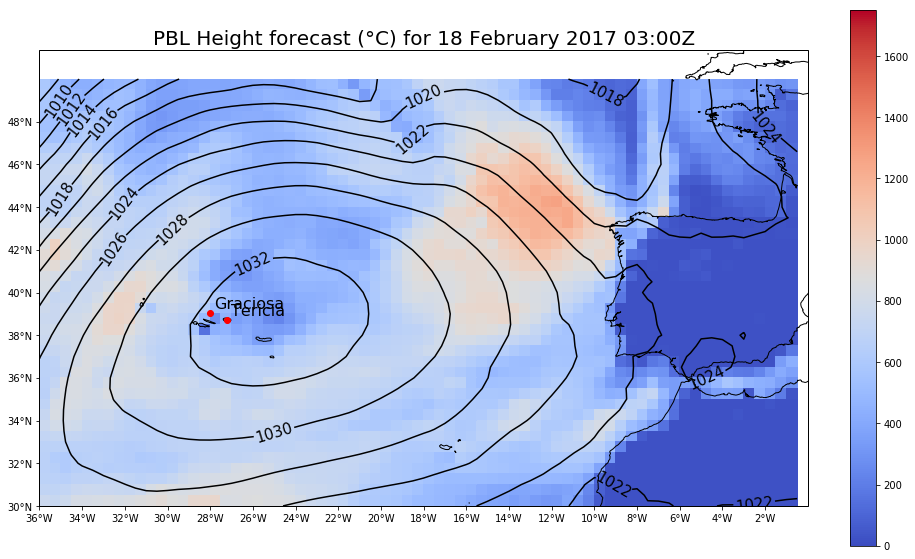

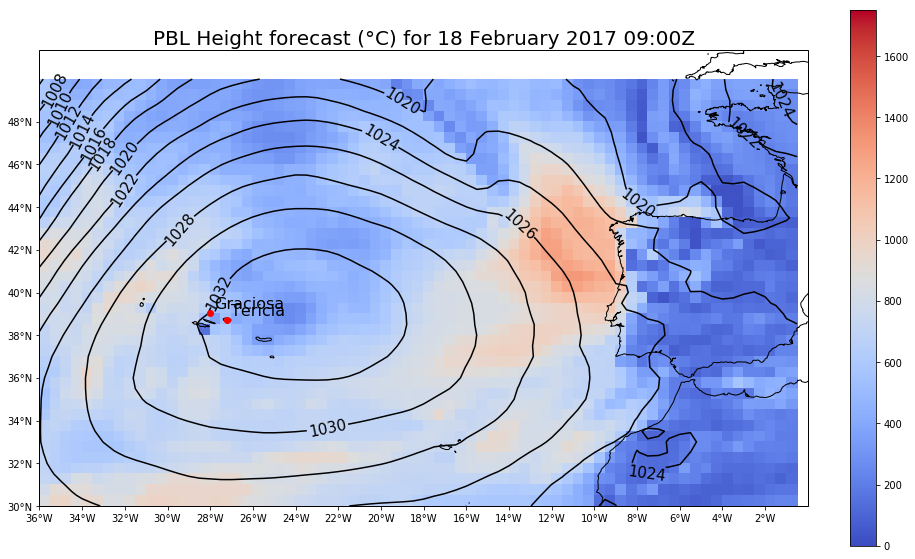

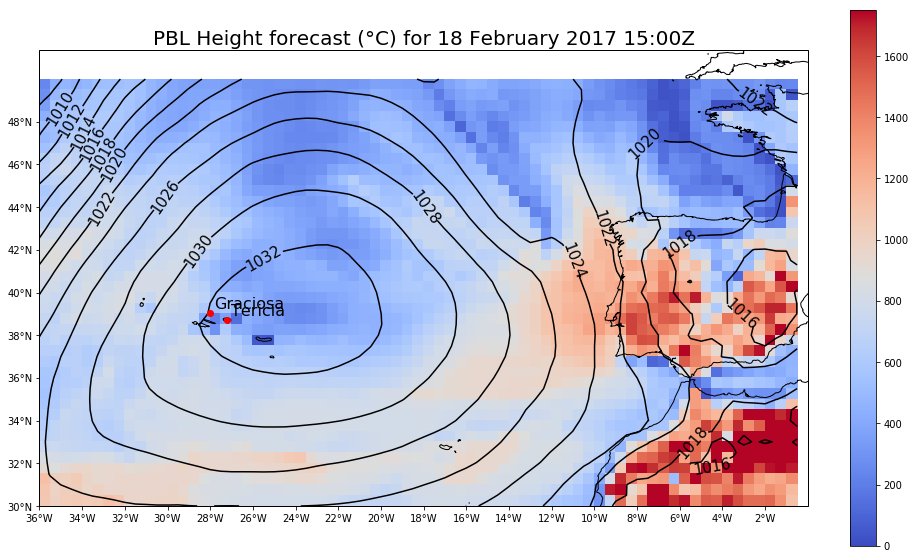

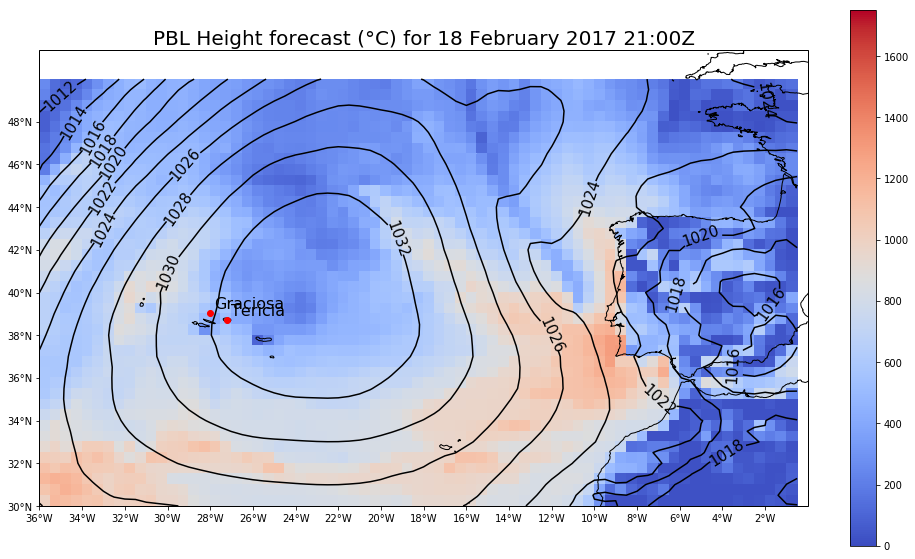

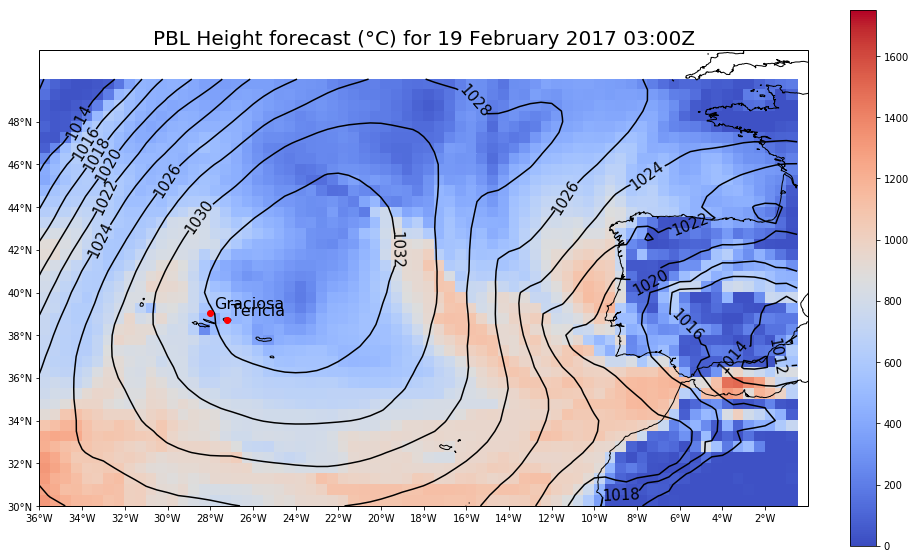

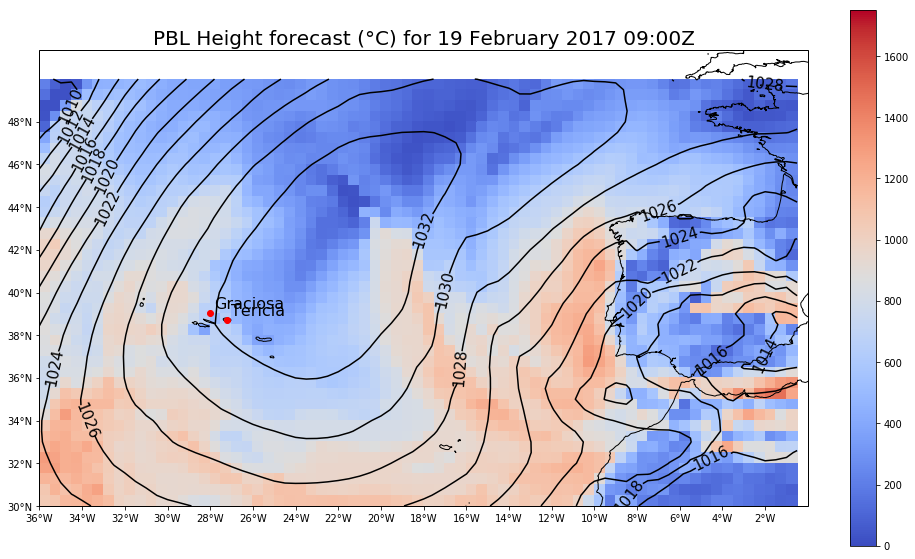

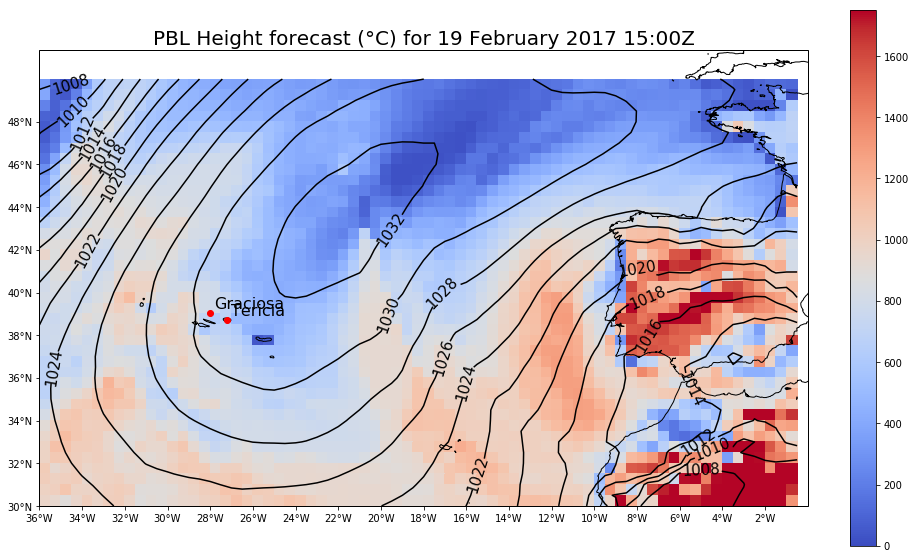

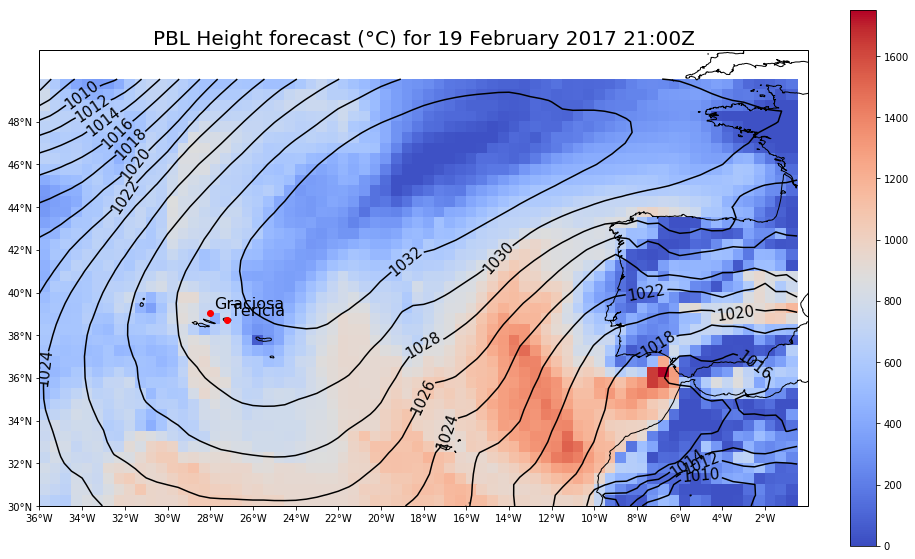

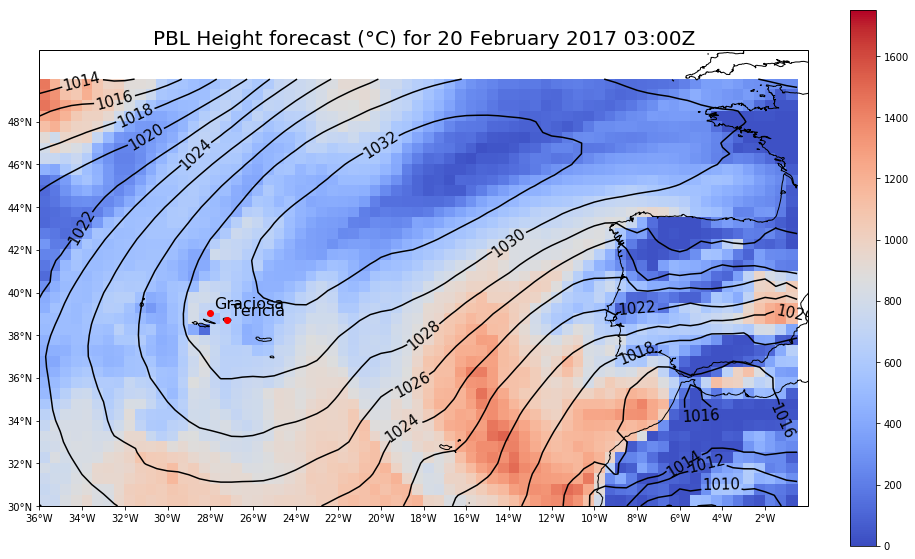

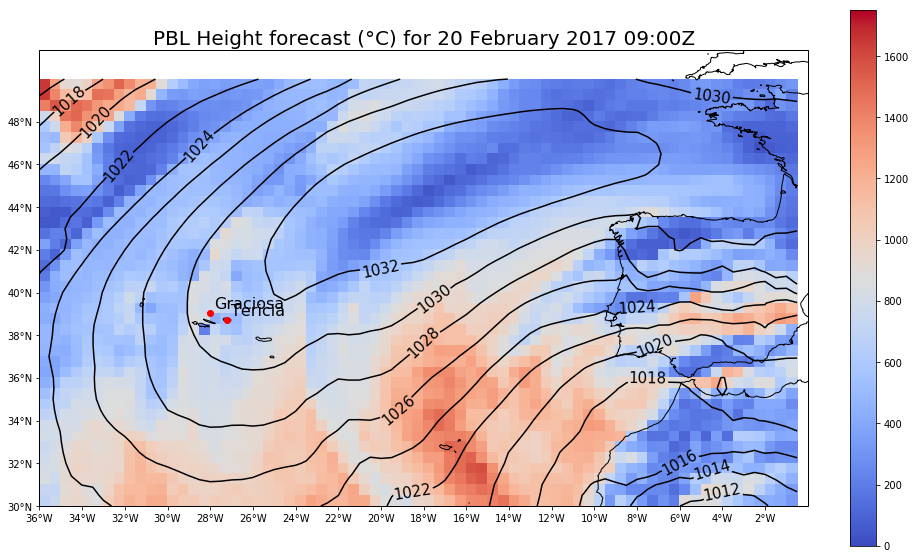

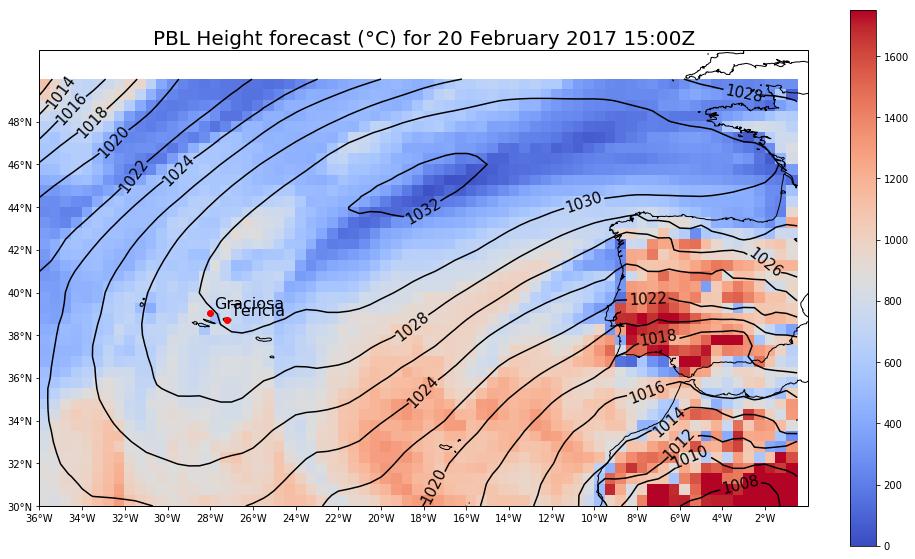

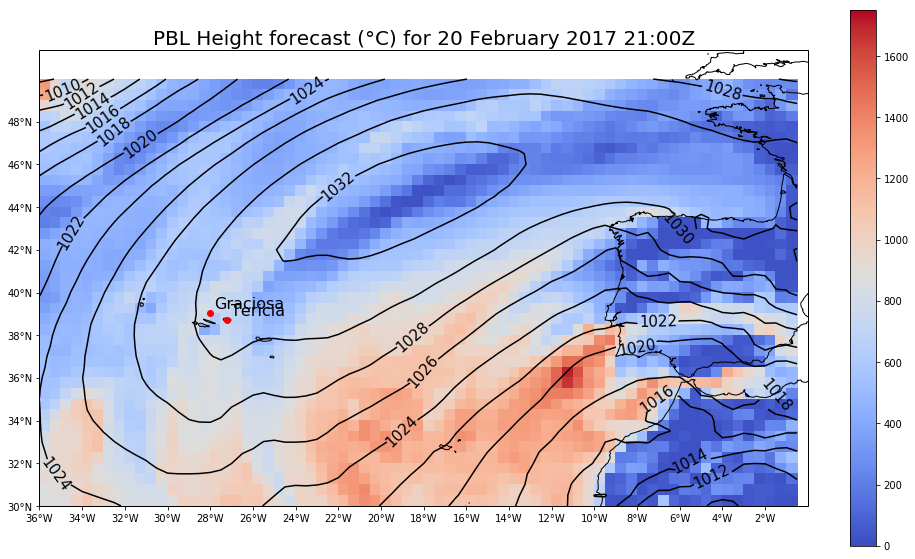

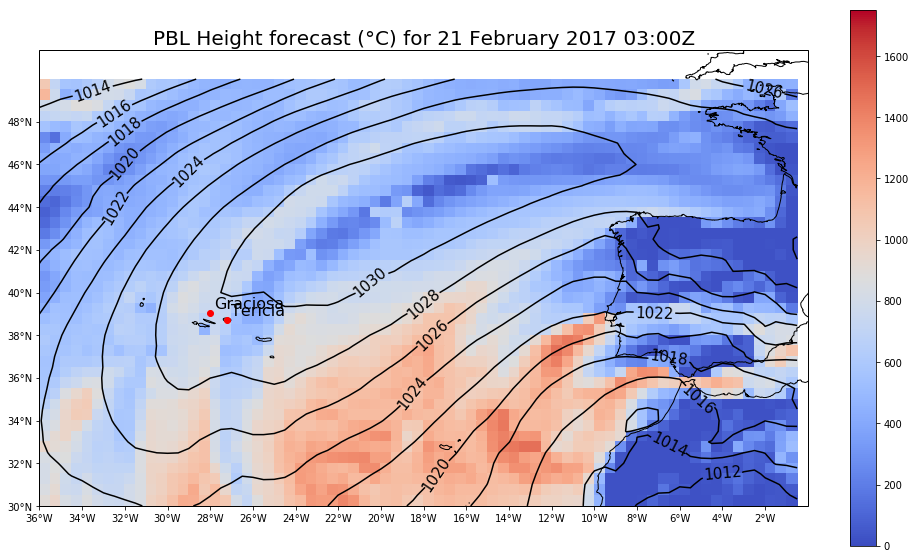

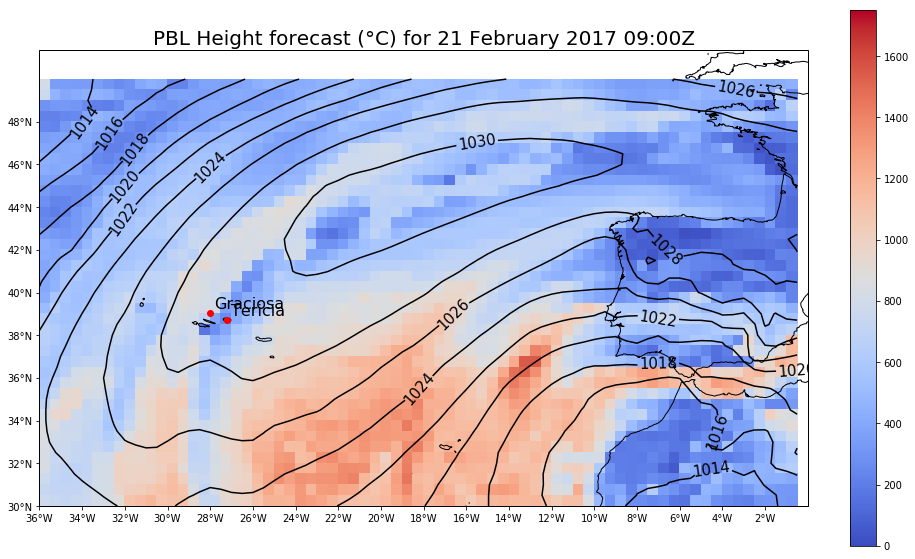

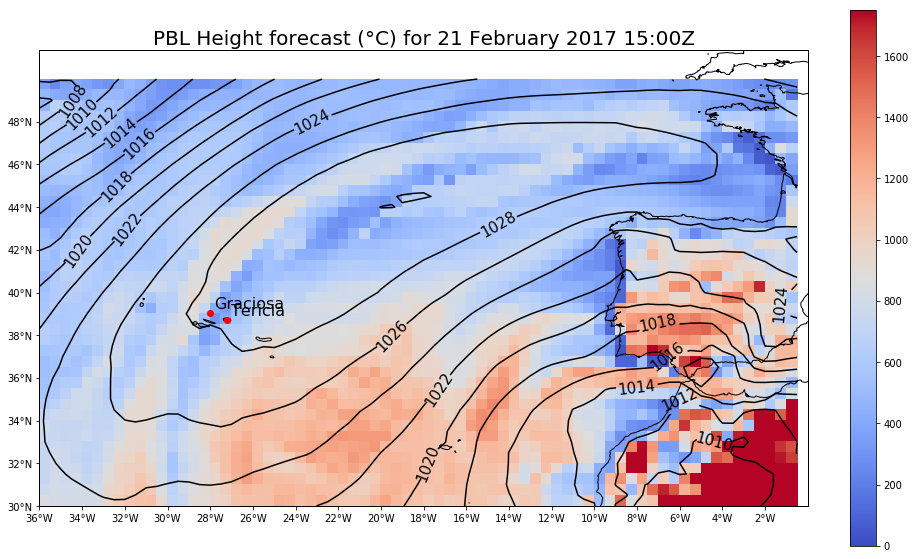

In [70]:
i = 0
for ts in np.arange(0,144,6):
    fname = '/Users/scollis//aceena_' + str(i).zfill(3) + '.png'
    print(fname)
    i += 1
    pblplot(ncss, [0, -36., 30, 50], delta=int(ts), tk=2)
    plt.savefig(fname)
    
    